In [15]:
# Filtering AVISO velocities and kinetic energy using gcm-filters 

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import gcm_filters

In [2]:
# single day of aviso gridded surface velocites, sea level anomaly (on 0.25 degree grid)
filename = ('/Users/jakesteinberg/Documents/CPT/spatial_filtering/aviso_ke_jan_6_2015.nc')
aviso = xr.open_dataset(filename)

In [3]:
aviso

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 ...
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
    time       datetime64[ns] ...
Data variables:
    adt        (latitude, longitude) float64 ...
    err        (latitude, longitude) float64 ...
    sla        (latitude, longitude) float64 ...
    ugos       (latitude, longitude) float64 ...
    ugosa      (latitude, longitude) float64 ...
    vgos       (latitude, longitude) float64 ...
    vgosa      (latitude, longitude) float64 ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [19]:
# extract and re-package into data-array with identical dimensions 
ke_og = 0.5*(aviso['ugos']**2 + aviso['vgos']**2)
du = xr.DataArray(
    data=aviso['ugos'].data,
    dims=["lat", "lon"],
    coords=dict(
    lon=(["lon"], aviso['longitude'].data),
    lat=(["lat"], aviso['latitude'].data),
    ),
)
dv = xr.DataArray(
    data=aviso['vgos'].data,
    dims=["lat", "lon"],
    coords=dict(
    lon=(["lon"], aviso['longitude'].data),
    lat=(["lat"], aviso['latitude'].data),
    ),
)
dKE = xr.DataArray(
    data=ke_og.data,
    dims=["lat", "lon"],
    coords=dict(
    lon=(["lon"], aviso['longitude'].data),
    lat=(["lat"], aviso['latitude'].data),
    ),
)

In [5]:
# -- cell area -- 
dy0 = 1852*60*(aviso['latitude'][2] - aviso['latitude'][1])
dx0 = 1852*60*np.cos(np.deg2rad(aviso['latitude']))*(aviso['longitude'][2] - aviso['longitude'][1])
area = dy0.data*np.tile(dx0, (len(aviso['longitude']),1))
area = np.transpose(area)
dA = xr.DataArray(
    data=area,
    dims=["lat", "lon"],
    coords=dict(
    lon=(["lon"], aviso['longitude'].data),
    lat=(["lat"], aviso['latitude'].data),
    ),
)

In [7]:
# -- wet mask -- 
Nx = len(area[1, :])
Ny = len(area[:, 1])
landMask = 0*np.random.randint(0,2,(Nx,Ny))
field_array = np.array(ke_og)
landMask[np.isnan(np.transpose(field_array))] = 1
landMask[np.transpose(field_array == 0)] = 1
landMask = np.transpose(landMask)
wetMask = 1 - landMask
dWM = xr.DataArray(
    data=wetMask,
    dims=["lat", "lon"],
    coords=dict(
    lon=(["lon"], aviso['longitude'].data),
    lat=(["lat"], aviso['latitude'].data),
    ),
)

In [9]:
# -- filter grid requirements -- 
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

In [23]:
filter_scale = 4
dx_min = 1
# initialze filter object for two filter types 
filter_simple_fixed_factor_G = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': dA, 'wet_mask': dWM}
)
filter_simple_fixed_factor_G

filter_simple_fixed_factor_T = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': dA, 'wet_mask': dWM}
)
filter_simple_fixed_factor_T

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=16, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [26]:
# filter velocities, filter KE, define EKE (for both Gaussian and Taper kernels)
u_filtered_simple_fixed_factor = filter_simple_fixed_factor.apply(du, dims=['lat', 'lon'])
v_filtered_simple_fixed_factor = filter_simple_fixed_factor.apply(dv, dims=['lat', 'lon'])
KE_uvfilt = 0.5*(u_filtered_simple_fixed_factor**2 + v_filtered_simple_fixed_factor**2)
KE_filtered_simple_fixed_factor = filter_simple_fixed_factor.apply(dKE, dims=['lat', 'lon'])

u_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(du, dims=['lat', 'lon'])
v_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(dv, dims=['lat', 'lon'])
KE_uvfilt_T = 0.5*(u_filtered_simple_fixed_factor_T**2 + v_filtered_simple_fixed_factor_T**2)
KE_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(dKE, dims=['lat', 'lon'])

eke_G = KE_filtered_simple_fixed_factor - KE_uvfilt
eke_T = KE_filtered_simple_fixed_factor_T - KE_uvfilt_T

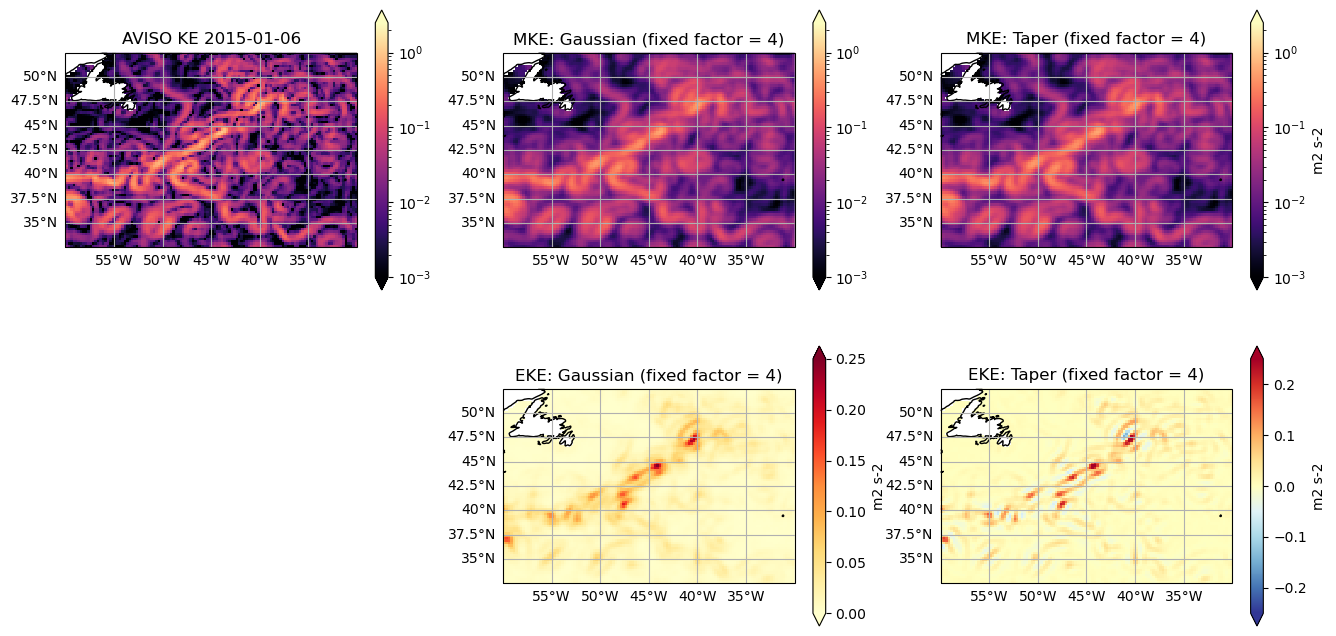

In [36]:
ke_lims = [0.001, 2.5]
ke_cmap = 'magma'
f,ax = plt.subplots(2,3,figsize=(16,8),subplot_kw={'projection':ccrs.PlateCarree()})
dKE.plot(ax=ax[0,0], cmap=ke_cmap, \
         norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,0].set(title='AVISO KE 2015-01-06')

KE_filtered_simple_fixed_factor.plot(ax=ax[0,1], cmap=ke_cmap, \
                                     norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,1].set(title='MKE: Gaussian (fixed factor = 4)')

KE_filtered_simple_fixed_factor.plot(ax=ax[0,2], cmap=ke_cmap, cbar_kwargs={'label': 'm2 s-2'}, \
                                     norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,2].set(title='MKE: Taper (fixed factor = 4)')

eke_G.plot(ax=ax[1,1], cmap='YlOrRd', cbar_kwargs={'label': 'm2 s-2'}, \
                                     vmin=0, vmax=0.25)
ax[1,1].set(title='EKE: Gaussian (fixed factor = 4)')

eke_T.plot(ax=ax[1,2], cmap='RdYlBu_r', cbar_kwargs={'label': 'm2 s-2'}, \
                                     vmin=-0.25, vmax=0.25)
ax[1,2].set(title='EKE: Taper (fixed factor = 4)')

gax = ax.flatten()
for i in [0,1,2,4,5]:
    gax[i].coastlines()
    gax[i].set_extent([300, 330, 32.5, 52.5], crs=ccrs.PlateCarree())
    gl = gax[i].gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
f.delaxes(ax[1,0])
plt.show()
f.savefig('aviso_ke_mke_eke.jpg', dpi=500)